#### Kaggle username - YiArch, team name - Александр_Ким

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder, SplineTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, ElasticNet
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score

from catboost import CatBoostClassifier
from xgboost import XGBClassifier

In [2]:
rs = 42
np.random.seed(rs)
os.environ['PYTHONHASHSEED'] = str(rs)

# 1. Exploration

## *1.1. Loading data*

In [3]:
input_path= "/kaggle/input/advanced-dls-spring-2021/"

In [4]:
# Two datasets for analysis and trials
data = pd.read_csv(input_path + 'train.csv')
test_data = pd.read_csv(input_path + 'test.csv')

In [5]:
# Some random strings

data.sample(10)

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
1448,9,45.40,418.8,Male,0,No,No,No,No phone service,DSL,No,No,No,No,Yes,Yes,Month-to-month,Yes,Electronic check,1
4792,37,70.35,2552.9,Male,0,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,0
8,50,105.95,5341.8,Male,0,Yes,Yes,Yes,Yes,Fiber optic,Yes,No,Yes,No,Yes,Yes,Month-to-month,No,Credit card (automatic),1
3964,44,100.10,4378.35,Male,0,No,No,Yes,No,Fiber optic,No,No,Yes,Yes,Yes,Yes,Two year,No,Bank transfer (automatic),0
240,25,20.95,495.15,Male,0,Yes,No,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Bank transfer (automatic),0
1942,39,50.75,2011.4,Female,0,No,No,No,No phone service,DSL,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,1
1859,52,79.20,4016.3,Male,0,Yes,Yes,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Electronic check,0
2348,1,74.40,74.4,Male,1,Yes,No,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,1
2280,6,50.80,288.05,Female,0,No,No,Yes,No,DSL,No,No,No,Yes,No,No,Month-to-month,Yes,Bank transfer (automatic),1
733,21,68.65,1493.2,Female,0,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,0


In [6]:
# Numerical features

num_cols = [
    'ClientPeriod',
    'MonthlySpending',
    'TotalSpent'
]

# Categorical features

cat_cols = [
    'Sex',
    'IsSeniorCitizen',
    'HasPartner',
    'HasChild',
    'HasPhoneService',
    'HasMultiplePhoneNumbers',
    'HasInternetService',
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasMovieSubscription',
    'HasContractPhone',
    'IsBillingPaperless',
    'PaymentMethod'
]

feature_cols = num_cols + cat_cols
target_col = 'Churn'

In [7]:
data.shape

(5282, 20)

## *1.2. Check for null values and empty cells*

In [8]:
# Check whether the dataframe has null values

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              5282 non-null   int64  
 1   MonthlySpending           5282 non-null   float64
 2   TotalSpent                5282 non-null   object 
 3   Sex                       5282 non-null   object 
 4   IsSeniorCitizen           5282 non-null   int64  
 5   HasPartner                5282 non-null   object 
 6   HasChild                  5282 non-null   object 
 7   HasPhoneService           5282 non-null   object 
 8   HasMultiplePhoneNumbers   5282 non-null   object 
 9   HasInternetService        5282 non-null   object 
 10  HasOnlineSecurityService  5282 non-null   object 
 11  HasOnlineBackup           5282 non-null   object 
 12  HasDeviceProtection       5282 non-null   object 
 13  HasTechSupportAccess      5282 non-null   object 
 14  HasOnlin

In [9]:
# Check for empty values

np.where(data.applymap(lambda x: x == ' '))

(array([1048, 1707, 2543, 3078, 3697, 4002, 4326, 4551, 4598]),
 array([2, 2, 2, 2, 2, 2, 2, 2, 2]))

We have 9 empty cells in *TotalSpent* column.

In [10]:
data.loc[data['TotalSpent'] == ' ']

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
1048,0,25.75,,Male,0,Yes,Yes,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
1707,0,73.35,,Female,0,Yes,Yes,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,0
2543,0,19.70,,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,0
3078,0,80.85,,Female,0,Yes,Yes,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,0
3697,0,20.00,,Female,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
4002,0,61.90,,Male,0,No,Yes,Yes,Yes,DSL,Yes,Yes,No,Yes,No,No,Two year,Yes,Bank transfer (automatic),0
4326,0,25.35,,Male,0,Yes,Yes,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
4551,0,52.55,,Female,0,Yes,Yes,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),0
4598,0,56.05,,Female,0,Yes,Yes,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),0


 Clearly these cells are for clients who didn't make payments yet, so replace them with 0 and create a variable for target column.

In [11]:
data.replace(r'^\s*$', 0, inplace=True, regex=True)

# Assign float type to TotalSpent as it is a numerical column

data["TotalSpent"] = data.TotalSpent.astype(float)
y = data[target_col]

Check test dataset and apply the same operation (replace empty with zeros) to it:

In [12]:
np.where(test_data.applymap(lambda x: x == ' '))

(array([177, 767]), array([2, 2]))

In [13]:
test_data.replace(r'^\s*$', 0, inplace=True, regex=True)
test_data["TotalSpent"] = test_data.TotalSpent.astype(float)

# 2. Data Analysis

## *2.1. Numerical features visualisation*

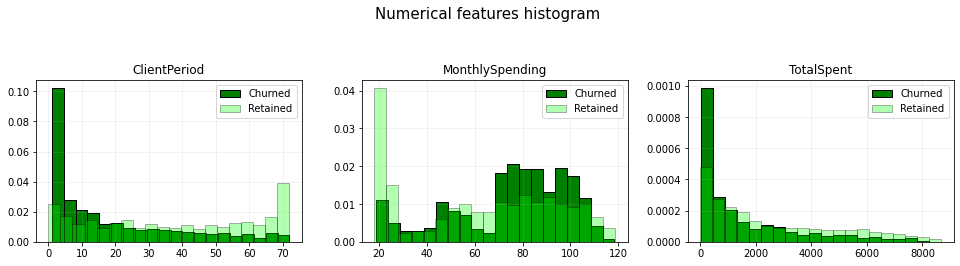

In [14]:
fig, axes = plt.subplots(1, 3, figsize=(14, 4))
fig.suptitle('Numerical features histogram', fontsize=15)
fig.tight_layout(pad=3)

for i, col in enumerate(num_cols):
    axes[i].set_title(col)
    axes[i].grid(alpha=0.2)
    axes[i].hist(data[data[target_col] == 1][col], color='green', edgecolor='black', density=True, bins=20, label='Churned')
    axes[i].hist(data[data[target_col] == 0][col], color='lime', edgecolor='black', alpha=0.3, density=True, bins=20, label='Retained')
    axes[i].legend()
plt.show()

## *2.2. Categorical features visualisation*

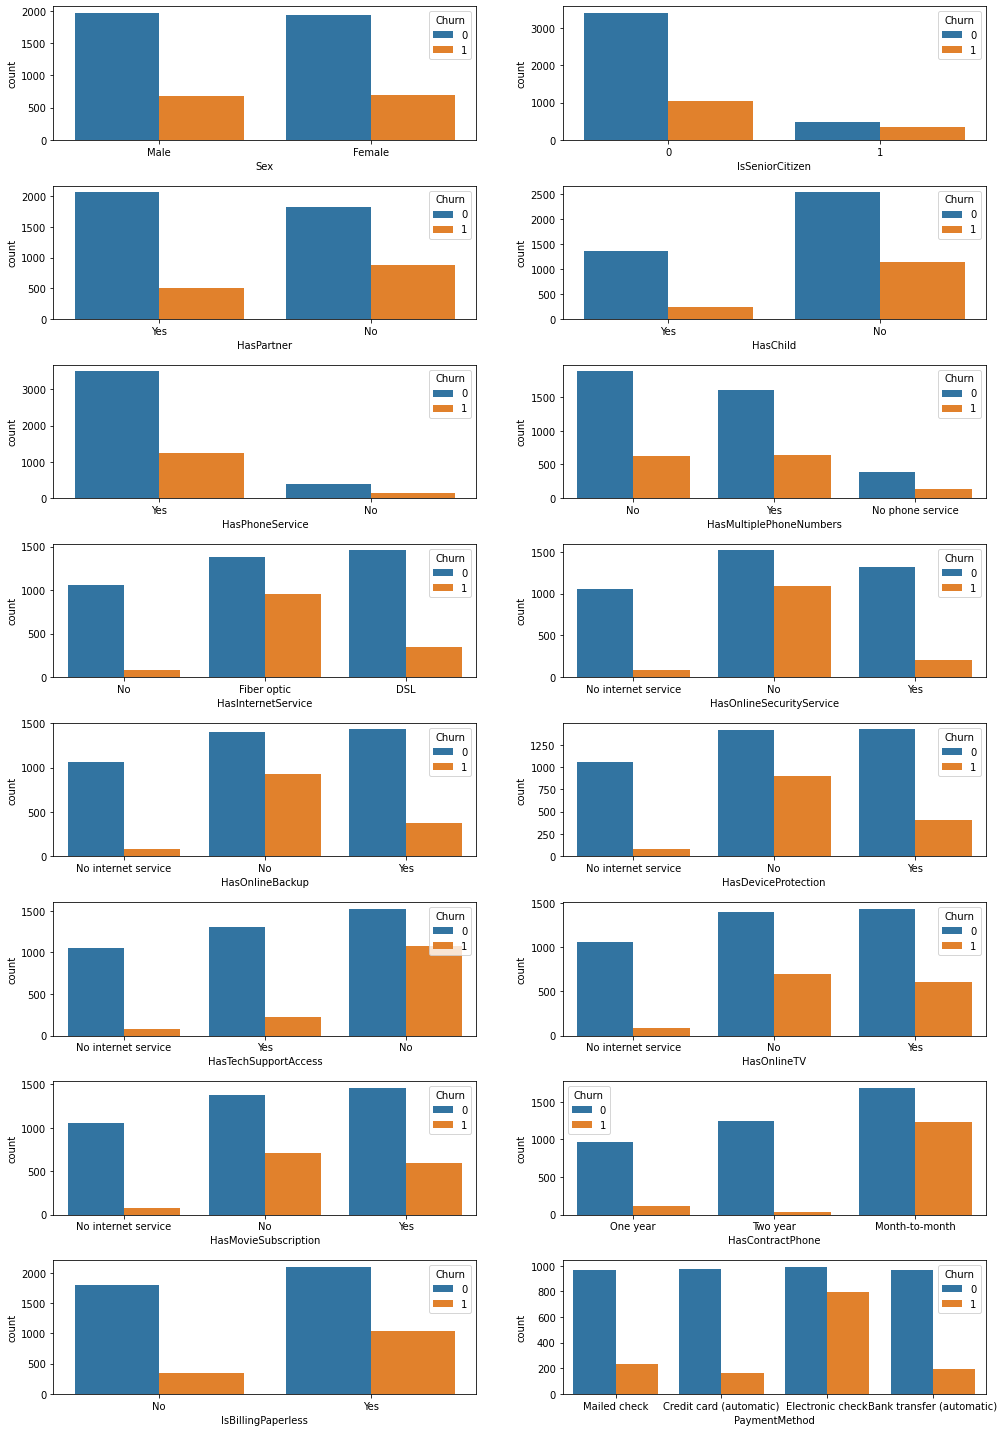

In [15]:
plt.figure(figsize=(14, 20))

for i, col in enumerate(cat_cols):
    ax = plt.subplot(8, 2, i+1)
    plt.tight_layout(w_pad=4)
    curr_col = sns.countplot(x=col, hue='Churn', data=data)

### *2.2.1. Some considerations on correlations*

Let's find some correlations if any. The most prominent churn bars are for 7 categories: *HasInternetService*, *HasOnlineSecurityService*, *HasOnlineBackup*, *HasDeviceProtection*, *HasTechSupportAccess*, *HasContractPhone* and *PaymentMethod*.

So, let's take a look at the numerical values:
<ul>Percent correlation between Internet service and churn:</ul>

In [16]:
print(data.groupby("HasInternetService").agg("Churn").sum()/
      data.groupby("HasInternetService").agg("Churn").count()*100)

HasInternetService
DSL            19.000000
Fiber optic    41.008116
No              7.186678
Name: Churn, dtype: float64


Users with fiber optic connection more tend to leave than stay.

<ul>Percent correlation with online security service:</ul>

In [17]:
print(data.groupby("HasOnlineSecurityService").agg("Churn").sum()/
      data.groupby("HasOnlineSecurityService").agg("Churn").count()*100)

HasOnlineSecurityService
No                     41.883614
No internet service     7.186678
Yes                    13.603663
Name: Churn, dtype: float64


Obvious churn for those without online security services.

<ul>The same situation with online backup, device protection, and tech support access:</ul>

In [18]:
print(data.groupby("HasOnlineBackup").agg("Churn").sum()/
      data.groupby("HasOnlineBackup").agg("Churn").count()*100, '\n')
print(data.groupby("HasDeviceProtection").agg("Churn").sum()/
      data.groupby("HasDeviceProtection").agg("Churn").count()*100, '\n')
print(data.groupby("HasTechSupportAccess").agg("Churn").sum()/
      data.groupby("HasTechSupportAccess").agg("Churn").count()*100)

HasOnlineBackup
No                     39.665523
No internet service     7.186678
Yes                    20.840243
Name: Churn, dtype: float64 

HasDeviceProtection
No                     38.843332
No internet service     7.186678
Yes                    22.039474
Name: Churn, dtype: float64 

HasTechSupportAccess
No                     41.244240
No internet service     7.186678
Yes                    14.834092
Name: Churn, dtype: float64


Clients who haven't got these sevices are more likely to leave.

<ul>Correlation with contract phone:</ul>

In [19]:
print(data.groupby("HasContractPhone").agg("Churn").sum()/
      data.groupby("HasContractPhone").agg("Churn").count()*100)

HasContractPhone
Month-to-month    42.157534
One year          11.090573
Two year           2.578125
Name: Churn, dtype: float64


So users with long-term contracts are less tend to leave.

<ul>Correlation with payment method:</ul>

In [20]:
print(data.groupby("PaymentMethod").agg("Churn").sum()/
      data.groupby("PaymentMethod").agg("Churn").count()*100)

PaymentMethod
Bank transfer (automatic)    16.824849
Credit card (automatic)      14.435696
Electronic check             44.456887
Mailed check                 19.262982
Name: Churn, dtype: float64


This correlation is not too clear, but obviously clients who prefer to pay with electronic check are more likely to churn.

Later on, however, it turned out that these features selection (while removing the rest) has almost no effect on the results of learning, so in the following sections all categorical features are fed to the input of the models.


### *2.2.2. Target feature distribution*

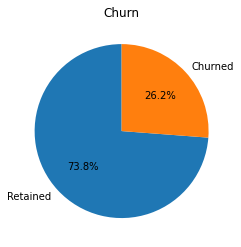

In [21]:
tc = data[target_col].value_counts()
plt.pie(tc, labels=('Retained', 'Churned'), autopct='%1.1f%%', startangle=90)
plt.title(target_col)
plt.show()

The last piechart shows that almost three quarters of clients are loyal to the company. According to this and plots above we can say that classes are rather **balanced**.

# 3. Prepare datasets for learning

## *3.1. Preprocessing for linear models and KNN*

Define a function for scaling numerical features and encoding categorical features. The resulting dataset will be used for linear models and KNN.

In [22]:
def scale_encode(dataset, scaler):
    num_columns = pd.DataFrame(scaler.fit_transform(dataset[num_cols]), columns=num_cols)
    cat_columns = pd.get_dummies(dataset[cat_cols])
    return pd.concat([num_columns, cat_columns], axis=1)

## *3.2. A custom-encoded dataset for gradient boosting*

The above analysis in the Section 2 leads to some conclusions:<br>
Note, there are many values "No phone service" and "No internet service" in the dataset. Obviously, if the client has no some service, "No" and "No internet/phone service" values will be equivalent. Thus we can make a **custom encoding** for categorical features, where "*No*", "*No internet service*" and "*No phone service*" can be replaced with zeroes. And it will be possible to replace other values with consecutive integers. Let's create a corresponding template for replace.

In [23]:
template = {
    'Male': 1,
    'Female': 0,
    'Yes': 1,
    'No': 0,
    'No phone service': 0,
    'Fiber optic': 2,
    'DSL': 1,
    'No internet service': 0,
    'One year': 0,
    'Two year': 1,
    'Month-to-month': 2,
    'Mailed check': 0,
    'Credit card (automatic)': 1,
    'Electronic check': 3,
    'Bank transfer (automatic)': 2
}

Create train and test datasets with custom encoding (empty values were replaced with zeros in *Section 1.2 Check for null values and empty cells*.):

In [24]:
custom_data = data.replace(template).drop(target_col, axis=1) # custom encoding dataset without target column
custom_test_data = test_data.replace(template) # test dataset has no "Churn" feature, so drop operation is not necessary

In [25]:
custom_data.sample(5)

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod
4055,46,74.80,3548.30,0,0,0,0,1,0,2,0,0,1,0,0,0,2,1,1
1060,1,50.55,50.55,0,0,0,0,1,0,1,0,1,0,0,0,0,2,0,3
2452,15,85.90,1269.55,0,0,0,1,1,0,2,0,1,0,0,0,1,2,1,2
2955,67,26.30,1688.90,1,0,1,1,1,1,0,0,0,0,0,0,0,1,0,0
3582,65,24.80,1600.95,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1


In [26]:
custom_test_data.sample(5)

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod
1484,21,45.65,985.05,1,0,0,1,1,0,1,0,0,0,0,0,0,2,0,0
598,1,54.90,54.90,0,0,0,0,1,0,1,1,1,0,0,0,0,2,1,3
843,1,49.75,49.75,1,0,0,0,1,0,1,1,0,0,0,0,0,2,0,3
1139,68,24.15,1498.85,1,0,0,0,1,1,0,0,0,0,0,0,0,1,1,2
517,1,72.10,72.10,0,1,0,0,1,1,2,0,0,0,0,0,0,2,1,3


Now we're ready for learning. Fit train datasets with different encodings using various models and compare results.

# 4. Testing linear models and KNN

## *4.1. Best model search*

Here we use various models and try to find the most promising with GridSearchCV</br>Define a function for fitting models with a range of parameters.

In [27]:
def estimators_comparison(X_train, y_train):
    
    param_grid = {
        'logistic_regression': {
            'model': LogisticRegression(random_state=rs),
            'params': {
                'C': [6.2], # np.linspace(0.1, 10, 100),
                'max_iter': [1000],
                'solver': ['lbfgs'] # ['sag', 'saga', 'newton-cg', 'lbfgs', 'liblinear']
            }
        },
        'elastic_net': {
            'model': ElasticNet(random_state=rs),
            'params': {
                'alpha': [0.1], # np.linspace(0.1, 1, 10),
                'l1_ratio': [0.1] #np.linspace(0.1, 1, 10)
            }
        },
        'knn': {
            'model': KNeighborsClassifier(),
            'params': {
                'n_neighbors': [77], # np.arange(1, 100),
                'weights': ['uniform'], # ['uniform', 'distance']
            }
        },
    }
    scores = []

    for name, value in param_grid.items():
        clf = GridSearchCV(value['model'], value['params'], cv=5, scoring='roc_auc', n_jobs=-1)
        clf.fit(X_train, y_train)
        scores.append({
            'model': name,
            'best_score': clf.best_score_,
            'best_params': clf.best_params_,
            'best_estimator': clf.best_estimator_
        })
        
    return scores

Now create scaled and encoded dataset and call the function above:

In [28]:
X = scale_encode(data, StandardScaler())
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=rs, test_size=0.2)
estimators_comparison(X_train, y_train)

[{'model': 'logistic_regression',
  'best_score': 0.84886389616231,
  'best_params': {'C': 6.2, 'max_iter': 1000, 'solver': 'lbfgs'},
  'best_estimator': LogisticRegression(C=6.2, max_iter=1000, random_state=42)},
 {'model': 'elastic_net',
  'best_score': 0.8412547683575051,
  'best_params': {'alpha': 0.1, 'l1_ratio': 0.1},
  'best_estimator': ElasticNet(alpha=0.1, l1_ratio=0.1, random_state=42)},
 {'model': 'knn',
  'best_score': 0.8408234483038107,
  'best_params': {'n_neighbors': 77, 'weights': 'uniform'},
  'best_estimator': KNeighborsClassifier(n_neighbors=77)}]

As we see, LogisticRegression gives the best results. Find roc-auc score on test split.

In [29]:
logreg = LogisticRegression(C=6.2, solver='lbfgs', max_iter=1000, random_state=rs, n_jobs=-1)
logreg.fit(X, y)
y_pred = logreg.predict_proba(X_test)[:,1]
print("Logistic Regression:", roc_auc_score(y_test, y_pred))

Logistic Regression: 0.831447807094504


Now try the model on the Kaggle dataset.

In [30]:
X_valid = scale_encode(test_data, StandardScaler())
submission = pd.read_csv(input_path + "submission.csv")
submission['Churn'] = logreg.predict_proba(X_valid)[:, 1]
submission.to_csv('./logreg.csv', index=False)

**Score on Kaggle test dataset with model fitted hyperparameter C=6.2 and 'lbfgs' solver is 0.84573**

Add the Kaggle result to dictionary to compare models performance in the end of the report.

In [31]:
kaggle_scores = dict()
kaggle_scores['LogisticRegression'] = [0.84573]

## *4.2. LogisticRegressionCV*

Now let's check the performance of LogisticRegressionCV on the whole train dataset.

In [32]:
c_values = np.linspace(0.1, 10, 100)
logregCV = LogisticRegressionCV(Cs=c_values, cv=5, max_iter=1000, n_jobs=-1, refit=True, scoring='roc_auc', random_state=rs)

In [33]:
logregCV.fit(X, y)
logregCV.predict_proba(X)
print(f'Logistic Regression on the dataset with custom encoding is {logregCV.score(X, y)} with hyperparameter C = {logregCV.C_[0]}')

Logistic Regression on the dataset with custom encoding is 0.8490287556683878 with hyperparameter C = 7.2


In [34]:
submission = pd.read_csv(input_path + "submission.csv")
submission['Churn'] = logregCV.predict_proba(X_valid)[:, 1]
submission.to_csv('./logregCV.csv', index=False)

**Score on Kaggle test dataset is 0.84574**

In [35]:
kaggle_scores['LogisticRegressionCV'] = [0.84574]

Clearly, both runs gave very close results, and the best one is 0.84574 obtained using LogisticRegressionCV with hyperparameter C=7.2.<br>This is a fairly good rate which means that the Logistic Regression model would predict clients churn with 85% probability.

# 5. Gradient boosting

This section focuses on three gradient boosting models: GradientBoostingClassifier from sklearn, CatBoostClassifier and XGBClassifier. All three models don't need numerical features scaling, and it's possible to use for them the custom-encoded dataset, prepared in *Section 3.2. A custom-encoded dataset for gradient boosting*. As for CatBoost, we'll also try to find model performance with default parameters and original dataset.

## *5.1. GradientBoostingClassifier*

In [36]:
X_train, X_test, y_train, y_test = train_test_split(custom_data, y, random_state=rs, test_size=0.2)

In [37]:
gbc = GradientBoostingClassifier()
gbc.fit(X_train, y_train)
gbc_params = {
    'loss': ['deviance'], # ['exponential', 'deviance'],
    'n_estimators': [100], # np.arange(50, 200, 10), # [190],
    'learning_rate': [0.09], # np.linspace(0.01, 0.1, 10),
    'max_depth': [3], # np.arange(3, 9),
    'min_samples_leaf': [90], # np.arange(50, 160, 10),
    'max_features': ['sqrt'], # ['sqrt', 'log2'],
    'random_state': [rs]
}

In [38]:
clf_gbc = GridSearchCV(gbc, param_grid=gbc_params, cv=5, scoring='roc_auc', n_jobs=-1)
clf_gbc.fit(X_train, y_train)
clf_gbc.best_params_

{'learning_rate': 0.09,
 'loss': 'deviance',
 'max_depth': 3,
 'max_features': 'sqrt',
 'min_samples_leaf': 90,
 'n_estimators': 100,
 'random_state': 42}

In [39]:
y_pred=clf_gbc.predict_proba(X_test)[:,1]
print("GradientBoostingClassifier:", roc_auc_score(y_test, y_pred))

GradientBoostingClassifier: 0.828430195509831


In [40]:
submission = pd.read_csv(input_path + "submission.csv")
submission['Churn'] = clf_gbc.predict_proba(custom_test_data)[:, 1]
submission.to_csv('./gbc_custom.csv', index=False)

**Score on Kaggle test dataset with model fitted on the dataset with custom encoding is 0.8523**<br>

In [41]:
kaggle_scores['GradBoost_custom'] = [0.8523]

## *5.2. CatBoostClassifier*

Next try CatBoost with default parameters.

In [42]:
X_cb = data[feature_cols]
X_train, X_test, y_train, y_test = train_test_split(X_cb, y, random_state=rs, test_size=0.2)

In [43]:
cb_default = CatBoostClassifier(cat_features=cat_cols, random_state=rs)
cb_default.fit(X_train, y_train, plot=False, verbose=False)
y_pred = cb_default.predict_proba(X_test)[:, -1]
roc_auc_score(y_test, y_pred)

0.821409111478468

In [44]:
X_cb_valid = test_data[feature_cols]
submission = pd.read_csv(input_path + "submission.csv")
submission['Churn'] = cb_default.predict_proba(X_cb_valid)[:, 1]
submission.to_csv('./catb_default.csv', index=False)

Now we'll try to find optimal parameters on train dataset with custom encoding.

In [45]:
X_cb_optimal = custom_data[feature_cols]
X_train, X_test, y_train, y_test = train_test_split(X_cb_optimal, y, random_state=rs, test_size=0.2)

In [46]:
cb_optimal = CatBoostClassifier(
    cat_features = cat_cols,
    loss_function='Logloss',
    eval_metric='AUC:hints=skip_train~false', 
    early_stopping_rounds=20,
    logging_level='Silent', 
    random_state=rs
)
param_grid = {
    'bootstrap_type': ['Bayesian'], # ['Bayesian', 'Bernoulli'],
    'learning_rate': [0.079], # np.linspace(0.01, 0.1, 100), # [0.0506],
    'l2_leaf_reg': [0.79], # np.linspace(0.01, 1, 100), # [0.05],
    'iterations': [110], # np.arange(50, 250, 10), # [190], [240],
    'max_depth': [3], # np.arange(2, 6), # [3],
    'grow_policy': ['Lossguide'], # ['SymmetricTree', 'Depthwise', 'Lossguide']
    'min_data_in_leaf': [120], # np.arange(100, 200, 10), # [120], [200]
    'random_strength': [1] # np.arange(1, 4)
}
cb_optimal.grid_search(param_grid, X_train, y_train, cv=5, plot=False, verbose=False, refit=True)
cb_optimal.get_params()

{'loss_function': 'Logloss',
 'logging_level': 'Silent',
 'eval_metric': 'AUC:hints=skip_train~false',
 'random_state': 42,
 'early_stopping_rounds': 20,
 'cat_features': ['Sex',
  'IsSeniorCitizen',
  'HasPartner',
  'HasChild',
  'HasPhoneService',
  'HasMultiplePhoneNumbers',
  'HasInternetService',
  'HasOnlineSecurityService',
  'HasOnlineBackup',
  'HasDeviceProtection',
  'HasTechSupportAccess',
  'HasOnlineTV',
  'HasMovieSubscription',
  'HasContractPhone',
  'IsBillingPaperless',
  'PaymentMethod'],
 'min_data_in_leaf': 120,
 'depth': 3,
 'random_strength': 1,
 'iterations': 110,
 'learning_rate': 0.079,
 'l2_leaf_reg': 0.79,
 'grow_policy': 'Lossguide',
 'bootstrap_type': 'Bayesian'}

In [47]:
cb_optimal.fit(X_cb_optimal, y, verbose=False)
y_pred = cb_optimal.predict_proba(X_test)[:, -1]
roc_auc_score(y_test, y_pred)

0.8375476768777532

In [48]:
X_cb_valid = custom_test_data[feature_cols]
submission = pd.read_csv(input_path + "submission.csv")
submission['Churn'] = cb_optimal.predict_proba(X_cb_valid)[:, 1]
submission.to_csv('./catb_optimal.csv', index=False)

**Score on Kaggle test dataset with default CatBoost model is 0.85148**<br>
**Score on Kaggle test dataset with model fitted on the dataset with custom encoding is 0.85413**

In [49]:
kaggle_scores['CatBoost_default'] = [0.85148]
kaggle_scores['CatBoost_custom'] = [0.85413]

## *5.3. XGBClassifier*

In [50]:
X_xgb_custom = custom_data[feature_cols]
X_train, X_test, y_train, y_test = train_test_split(X_xgb_custom, y, random_state=rs, test_size=0.2)

In [51]:
param_grid = {
    "max_depth": [3], # [3, 4, 5, 7],
    "learning_rate": [0.1], # [0.1, 0.01, 0.05],
    "gamma": [1], # [0, 0.25, 1],
    "reg_lambda": [100], # [0, 1, 10],
    "scale_pos_weight": [0.5], # [1, 3, 5],
    "subsample": [0.8],
    "colsample_bytree": [0.5],
}
xgb_model = XGBClassifier(objective="binary:logistic", random_state=rs)
clf_xgb = GridSearchCV(xgb_model, param_grid, n_jobs=-1, cv=5, scoring="roc_auc")
clf_xgb.fit(X_train, y_train)
clf_xgb.best_score_

0.84848121933669

In [52]:
y_pred = clf_xgb.predict_proba(X_test)[:, 1]
roc_auc_score(y_test, y_pred)

0.8248607788993453

In [53]:
X_xgb_valid = custom_test_data[feature_cols]
submission = pd.read_csv(input_path + "submission.csv")
submission['Churn'] = clf_xgb.predict_proba(X_xgb_valid)[:, 1]
submission.to_csv('./xgb_custom.csv', index=False)

**Score on Kaggle test dataset with model fitted on the dataset with custom encoding is 0.84967**

In [54]:
kaggle_scores['XGBC_custom'] = [0.84967]

# 6. Summary

We collected some scores for Kaggle dataset and now it's time to chose a leader.

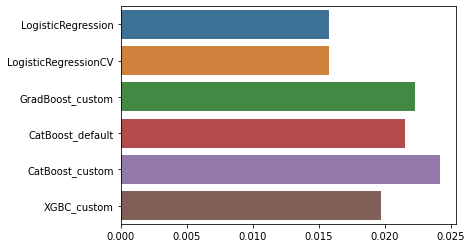

In [55]:
final_res = pd.DataFrame(kaggle_scores)-0.83 # Results are scaled to better show the differences
scores_hist = sns.barplot(data=final_res, orient='h', saturation=0.6)

In [56]:
keys = ["cat_features", "logging_level", "eval_metric", 'random_state', 'early_stopping_rounds']
best_params = cb_optimal.get_params()
for key in keys:
    del best_params[key]
print(f"As one can see, CatBoost model with custom-encoded data showed the best result {kaggle_scores['CatBoost_custom']} with the following parameters:")
best_params

As one can see, CatBoost model with custom-encoded data showed the best result [0.85413] with the following parameters:


{'loss_function': 'Logloss',
 'min_data_in_leaf': 120,
 'depth': 3,
 'random_strength': 1,
 'iterations': 110,
 'learning_rate': 0.079,
 'l2_leaf_reg': 0.79,
 'grow_policy': 'Lossguide',
 'bootstrap_type': 'Bayesian'}

In [57]:
best_model = cb_optimal
submission['Churn'] = best_model.predict_proba(X_cb_valid)[:, 1]
submission.to_csv('./submission.csv', index=False)